# 传统价值因子算法

By Gil Wassermann

Strategy taken from "130/30: The New Long-Only" by Andrew Lo and Pankaj Patel

Part of the Quantopian Lecture Series:
* www.quantopian.com/lectures
* github.com/quantopian/research_public



在2007年危机之前，130/30基金风靡一时。130/30基金的想法很简单:做多130%做空30%;这种组合带来了100%的净风险敞口(与只做多的基金相同)，以及做空股票的额外好处。在交易策略中做空的能力至关重要，因为它能让基金经理从一只股票的糟糕表现中获利，而这在传统的只做多策略中是不可能的。

这个本子将使用Andrew Lo和Pankaj Patel在“130/30:New Long Only”中概述的因素来演示如何创建一个算法的130/30策略。它还将突出quant的管道API，这是一个开发要素交易策略的强大工具。

首先，让我们导入此算法所需的所有库和函数

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import CustomFactor

# 传统的价值

在这个笔记本中，我们将开发一个基于Lo/Patel白皮书中描述的“传统价值”度量的策略。这种策略中使用的因素使用经典的基本面分析将股票分为便宜和昂贵两种。Lo/Patel使用的因素有:

* 股息收益率
* 价格与账面价值之比
* 价格与过去12个月销售额之比
* 价格与过去12个月现金流之比

## 股息收益率

股息收益率计算如下:

$$Dividend\;Yield = \frac{Annual\;Dividends\;per\;share}{Price\;per\;share}$$

当一个公司盈利时，它面临一个选择。它可以将这些利润再投资于公司，以提高效率，购买新技术等，或者它可以向股东支付股息。尽管再投资可能会提高公司未来的股价，从而回报投资者，但股东获得回报的最具体方式是通过股息。高股息率的股票尤其具有吸引力，因为向投资者支付的股息占股价的比例更大。现在，我们将使用管道API框架和管道的基本值列表来创建股息收益率因子。

In [2]:
# Custom Factor 1 : Dividend Yield
class Div_Yield(CustomFactor):
    inputs = [Fundamentals.div_yield5_year]
    window_length = 1
    def compute(self, today, assets, out, d_y):
        out[:] = d_y[-1]

虽然可以使用其他基本度量来计算这个因素，但是基本原理不需要进行任何计算。在从零开始创建自定义因素之前，最好检查一下[基本面](https://www.quantopian.com/help/fundamentals)列表。

我们将初始化一个临时管道，以了解这些值。

In [3]:
# create the pipeline
temp_pipe_1 = Pipeline()

# add the factor to the pipeline
temp_pipe_1.add(Div_Yield(), 'Dividend Yield')

# run the pipeline and get data for first 5 equities
run_pipeline(temp_pipe_1, start_date = '2015-11-11', end_date = '2015-11-11').dropna().head()

Dividend Yield
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])           0.0110
                          Equity(41 [ARCB])          0.0064
                          Equity(52 [ABM])           0.0240
                          Equity(62 [ABT])           0.0279
                          Equity(64 [ABX])           0.0192

## 价格与账面价值之比

价格与账面价值之比，即市净率，计算方法如下:

$$P/B\;Ratio = \frac{Price\;per\;share}{Net\;Asset\;Value\;per\;share}$$

每股资产净值可以认为(非常粗略地)是一家公司的总资产减去总负债，再除以发行在外的股票数量。

市盈率给人一种股票要么被高估要么被低估的感觉。高市盈率意味着股票价格被高估，因此应该做空，而低市盈率是有吸引力的，因为通过购买股票而获得的股票假设“价值高于”所支付的价格。

现在，我们将创建一个P/B比率自定义因子，并查看一些结果。

In [4]:
# Custom Factor 2 : P/B Ratio
class Price_to_Book(CustomFactor):
    inputs = [Fundamentals.pb_ratio]
    window_length = 1

    def compute(self, today, assets, out, pbr):
        out[:] = pbr[-1]
        
# create the Pipeline
temp_pipe_2 = Pipeline()

# add the factor to the Pipeline
temp_pipe_2.add(Price_to_Book(), 'P/B Ratio')

# run the Pipeline and get data for first 5 equities
run_pipeline(temp_pipe_2, start_date='2015-11-11', end_date='2015-11-11').head()

P/B Ratio
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])       0.899825
                          Equity(21 [AAME])      0.976077
                          Equity(24 [AAPL])      5.632086
                          Equity(25 [ARNC_PR])        NaN
                          Equity(31 [ABAX])      5.281542

关于这个数据系列，有两点需要说明。

首先，通过管道将AA_PR的P/B比率表示为NaN。NaN代表“not a number”，当一个值不能通过管道获取时发生。最后，我们将从数据集中删除这些NaN值，因为它们在操作数据时经常导致令人困惑的错误。

其次，低P/B和高股息率对投资者有吸引力，而高P/B和低股息率对投资者没有吸引力。因此，我们将通过使因子输出中的每个值为负来“反转”P/B比率，以便在以后的算法中聚合数据时，最大值和最小值具有相同的底层“含义”。

## 价格与过去12个月销售额之比

这是计算每股价格和过去12个月(TTM)销售额之间的简单比率。

TTM是一种转换，而不是一种度量，它可以有效地计算一年前某个特定季度的基本价值的改善或恶化。举个例子,如果一个人想要计算今天的TTM销售公司XYZ,一个将最近一个季度的收入除以本季度的收入之间的差异和本季度的收入去年增加了收入的公司最近财政年终申报。

使用管道确实可以计算出一个安全的确切TTM;但是，所需的代码很慢。幸运的是，这个价值可以很好地用内置的基本晨星比率来近似，该比率使用年度销售来计算价格与销售基本价值之比。这一微小的变化极大地提高了代码的速度，但对策略本身的结果几乎没有影响。

在功能方面，TTM销售额与价格之比与P/B比相似。这两个比率的主要区别在于，TTM的加入意味着季节波动被最小化，因为之前的数据是用来平滑值的。在我们的例子中，年化值完成了同样的平滑。

另外，请注意产生的值是负数;这个因素需要与P/B比率相同的反演。

In [5]:
# Custom Factor 3 : Price to Trailing 12 Month Sales       
class Price_to_TTM_Sales(CustomFactor):
    inputs = [Fundamentals.ps_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, ps):
        out[:] = -ps[-1]
        
# create the pipeline
temp_pipe_3 = Pipeline()

# add the factor to the pipeline
temp_pipe_3.add(Price_to_TTM_Sales(), 'Price / TTM Sales')

# run the pipeline and get data for first 5 equities
run_pipeline(temp_pipe_3, start_date='2015-11-11', end_date='2015-11-11').head()

Price / TTM Sales
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])              -0.453038
                          Equity(21 [AAME])             -0.629844
                          Equity(24 [AAPL])             -2.988556
                          Equity(25 [ARNC_PR])                NaN
                          Equity(31 [ABAX])             -5.640918

## 过去12个月的现金流与价格之比

这是计算每股价格和TTM自由现金流的简单比率(这里使用内置的基本晨星比率作为近似)。

这个比率的功能与前两个类似。未来的记事本将探索这些指标的细微差别，但它们的目的大致相同。同样，低值有吸引力，高值没有吸引力，因此度量必须是相反的。

In [6]:
# Custom Factor 4 : Price to Trailing 12 Month Cashflow
class Price_to_TTM_Cashflows(CustomFactor):
    inputs = [Fundamentals.pcf_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pcf):
        out[:] = -pcf[-1] 
        
# create the pipeline
temp_pipe_4 = Pipeline()

# add the factor to the pipeline
temp_pipe_4.add(Price_to_TTM_Cashflows(), 'Price / TTM Cashflows')

# run the pipeline and get data for first 5 equities
run_pipeline(temp_pipe_4, start_date='2015-11-11', end_date='2015-11-11').head()

Price / TTM Cashflows
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])                  -4.929472
                          Equity(21 [AAME])                -34.732899
                          Equity(24 [AAPL])                 -8.594865
                          Equity(25 [ARNC_PR])                    NaN
                          Equity(31 [ABAX])                -42.920180

## 完整的管道

既然已经添加了每个单独的因素，现在就该立即获取所有必要的数据了。在算法中，这将每天发生一次。

在稍后的过程中，我们将需要一个因子来创建一个近似的标准普尔500指数，因此我们还将包括另一个因子SPY_proxy (SPY是跟踪标准普尔500指数的ETF)。标准普尔500指数是500家在股票市场上交易的最大公司的集合。我们对标准普尔500指数的解释是500家市值最高的公司;然而，实际的标准普尔500指数将略有不同，因为创建该指数的标准普尔(Standard and Poors)有更微妙的计算算法。

我们还将改变我们的P/B比率因子，以说明反演。

In [7]:
# This factor creates the synthetic S&P500
class SPY_proxy(CustomFactor):
    inputs = [Fundamentals.market_cap]
    window_length = 1
    
    def compute(self, today, assets, out, mc):
        out[:] = mc[-1]
        
# Custom Factor 2 : P/B Ratio
class Price_to_Book(CustomFactor):
    inputs = [Fundamentals.pb_ratio]
    window_length = 1

    def compute(self, today, assets, out, pbr):
        out[:] = -pbr[-1]
        
def Data_Pull():
    
    # create the piepline for the data pull
    Data_Pipe = Pipeline()
    
    # create SPY proxy
    Data_Pipe.add(SPY_proxy(), 'SPY Proxy')

    # Div Yield
    Data_Pipe.add(Div_Yield(), 'Dividend Yield') 
    
    # Price to Book
    Data_Pipe.add(Price_to_Book(), 'Price to Book')
    
    # Price / TTM Sales
    Data_Pipe.add(Price_to_TTM_Sales(), 'Price / TTM Sales')
    
    # Price / TTM Cashflows
    Data_Pipe.add(Price_to_TTM_Cashflows(), 'Price / TTM Cashflow')
        
    return Data_Pipe

# NB: Data pull is a function that returns a Pipeline object, so need ()
results = run_pipeline(Data_Pull(), start_date='2015-11-11', end_date='2015-11-11')
results.head()

Dividend Yield  \
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])               0.011   
                          Equity(21 [AAME])                NaN   
                          Equity(24 [AAPL])                NaN   
                          Equity(25 [ARNC_PR])             NaN   
                          Equity(31 [ABAX])                NaN   

                                                Price / TTM Cashflow  \
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])                 -4.929472   
                          Equity(21 [AAME])               -34.732899   
                          Equity(24 [AAPL])                -8.594865   
                          Equity(25 [ARNC_PR])                   NaN   
                          Equity(31 [ABAX])               -42.920180   

                                                Price / TTM Sales  \
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])              -0.453038   
                          Equity(21 [AAME])             -0.629844   
                          Equity(24 [AAPL])             -2.988556   
                          Equity(25 [ARNC_PR])                NaN   
                          Equity(31 [ABAX])             -5.640918   

                                                Price to Book     SPY Proxy  
2015-11-11 00:00:00+00:00 Equity(2 [ARNC])          -0.899825  1.128021e+10  
                          Equity(21 [AAME])         -0.976077  1.029634e+08  
                          Equity(24 [AAPL])         -5.632086  6.722177e+11  
                          Equity(25 [ARNC_PR])            NaN           NaN  
                          Equity(31 [ABAX])         -5.281542  1.186963e+09

## 聚合

现在我们有了所有的数据，我们需要操纵这些数据来创建证券的单一排名。Lo/Patel推荐以下算法:

* 从权益集中提取标准普尔500，并找到该数据集的每个因素的平均值和标准偏差(standard_frame_compute)

* 使用这些计算值来标准化每个因素(standard_frame_compute)

* 将大于10或小于-10的值分别替换为10和-10，以限制离群值的影响(filter_fn)

* 将每个权益的这些值相加，然后除以因子的数量，得到-10到10之间的值(综合分数)

其代码如下所示。

In [8]:
# limit effect of outliers
def filter_fn(x):
    if x <= -10:
        x = -10.0
    elif x >= 10:
        x = 10.0
    return x   

# standardize using mean and sd of S&P500
def standard_frame_compute(df):
    
    # basic clean of dataset to remove infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    
    # need standardization params from synthetic S&P500
    df_SPY = df.sort(columns='SPY Proxy', ascending=False)

    # create separate dataframe for SPY
    # to store standardization values
    df_SPY = df_SPY.head(500)
    
    # get dataframes into numpy array
    df_SPY = df_SPY.as_matrix()
    
    # store index values
    index = df.index.values
    df = df.as_matrix()
    
    df_standard = np.empty(df.shape[0])
    
    
    for col_SPY, col_full in zip(df_SPY.T, df.T):
        
        # summary stats for S&P500
        mu = np.mean(col_SPY)
        sigma = np.std(col_SPY)
        col_standard = np.array(((col_full - mu) / sigma)) 

        # create vectorized function (lambda equivalent)
        fltr = np.vectorize(filter_fn)
        col_standard = (fltr(col_standard))
        
        # make range between -10 and 10
        col_standard = (col_standard / df.shape[1])
        
        # attach calculated values as new row in df_standard
        df_standard = np.vstack((df_standard, col_standard))
     
    # get rid of first entry (empty scores)
    df_standard = np.delete(df_standard,0,0)
    
    return (df_standard, index)

# Sum up and sort data
def composite_score(df, index):

    # sum up transformed data
    df_composite = df.sum(axis=0)
    
    # put into a pandas dataframe and connect numbers
    # to equities via reindexing
    df_composite = pd.Series(data=df_composite,index=index)
    
    # sort descending
    df_composite.sort_values(ascending=False)

    return df_composite

# compute the standardized values
results_standard, index = standard_frame_compute(results)

# aggregate the scores
ranked_scores = composite_score(results_standard, index)

# print the final rankings
ranked_scores

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:66: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


(2015-11-11 00:00:00+00:00, Equity(35162 [ARR]))      1.941979
(2015-11-11 00:00:00+00:00, Equity(27019 [WIN]))      1.670852
(2015-11-11 00:00:00+00:00, Equity(39622 [NKA]))      1.631767
(2015-11-11 00:00:00+00:00, Equity(28076 [RSO]))      1.575746
(2015-11-11 00:00:00+00:00, Equity(32675 [BBEP]))     1.508037
(2015-11-11 00:00:00+00:00, Equity(27993 [LINE]))     1.448997
(2015-11-11 00:00:00+00:00, Equity(11461 [DOM]))      1.439093
(2015-11-11 00:00:00+00:00, Equity(24102 [NRP]))      1.415778
(2015-11-11 00:00:00+00:00, Equity(5061 [MSFT]))      1.408201
(2015-11-11 00:00:00+00:00, Equity(34662 [NYMT]))     1.333686
(2015-11-11 00:00:00+00:00, Equity(8347 [XOM]))       1.324958
(2015-11-11 00:00:00+00:00, Equity(33159 [LGCY]))     1.251848
(2015-11-11 00:00:00+00:00, Equity(33178 [MVO]))      1.247968
(2015-11-11 00:00:00+00:00, Equity(38477 [CYS]))      1.226731
(2015-11-11 00:00:00+00:00, Equity(35054 [NMM]))      1.213649
(2015-11-11 00:00:00+00:00, Equity(3149 [GE]))        1

## 股票的选择

现在我们已经对我们的证券进行了排序，我们需要选择一个长篮子和一个短篮子。既然我们需要在多头和空头之间保持130/30的比例，为什么不拥有26多头和6空头(在算法中，我们将平均衡量每一个多头和6个空头，从而得到我们想要的杠杆和敞口)。

在下面的图表中，我们绘制了证券的柱状图来了解分数的分布。红线表示长桶和短桶的截止点。值得注意的一点是，绝大多数股票的排名都在柱状图的中间，而尾部则非常薄。这将表明，在这些篮子中选择的证券有一些特别之处，而且——希望如此——这些特别的品质将为该策略产生正的阿尔法。

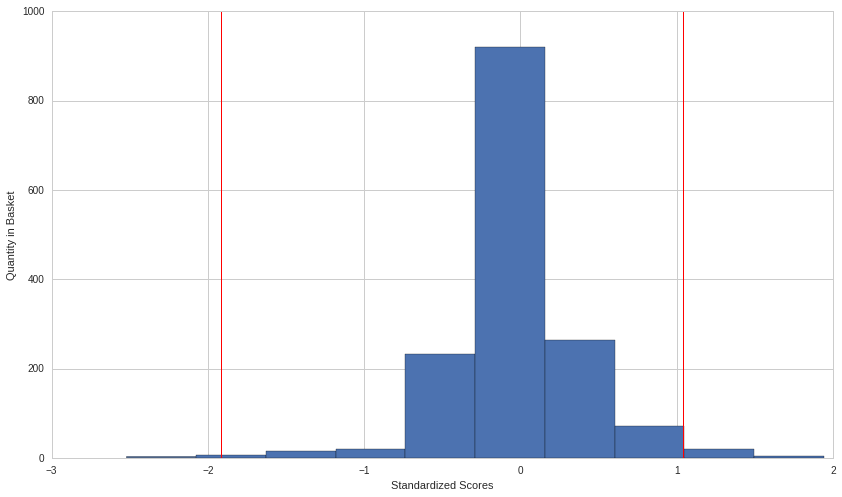

In [9]:
# create histogram of scores
ranked_scores.hist()

# make scores into list for ease of manipulation
ranked_scores_list = ranked_scores.tolist()

# add labels to axes
plt.xlabel('Standardized Scores')
plt.ylabel('Quantity in Basket')

# show long bucket
plt.axvline(x=ranked_scores_list[25], linewidth=1, color='r')

# show short bucket
plt.axvline(x=ranked_scores_list[-6], linewidth=1, color='r');

请参阅完整的算法回测回报!

注:在算法的实现中，为了保证只包含可交易股票，使用了一系列的过滤器。这个过滤器的方法可以在https://www.quantopian.com/posts/pipeline-trading-universe-best-practice 找到。